# Session 3 - Training a Network w/ TF

In [1]:
# imports

# check py ver
import sys
if sys.version_info < (3,4):
    print('This version of Python is too old. Please update to at least 3.4.')

# libs
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
except ImportError:
    print('You are missing some libraies!')
    # wild - we can `pip install` here!
    #!pip install "numpy>1.11.0" "matplotlib>1.5.1" "scikit-image>0.11.3" "scikit-learn>=0.17" "scipy>=0.17.0"
    
# tf
try:
    import tensorflow as tf
except ImportError:
    print('You need TensorFlow for this course about artistic applications of TensorFlow.')
    
try:
    from libs import utils, gif
    import IPython.display as ipyd
except ImportError:
    print('Make sure you have the libs stuff in the same directory as this notebook.')

In [2]:
# pk doesn't like the default inline code style, so let's jazz up the CSS:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code {
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
}</style>""")

In [3]:
%matplotlib inline
plt.style.use('ggplot')

## Part One - Fully Connected Network

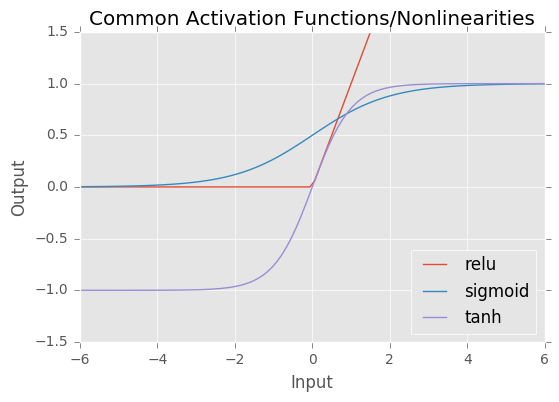

In [4]:
xs = np.linspace(-6, 6, 100)
plt.plot(xs, np.maximum(xs, 0), label='relu')
plt.plot(xs, 1 / (1 + np.exp(-xs)), label='sigmoid')
plt.plot(xs, np.tanh(xs), label='tanh')
plt.xlabel('Input')
plt.xlim([-6, 6])
plt.ylabel('Output')
plt.ylim([-1.5, 1.5])
plt.title('Common Activation Functions/Nonlinearities')
plt.legend(loc='lower right')

### Code

In [5]:
X = tf.placeholder(tf.float32, shape=[None, 2], name='X')

In [6]:
W = tf.get_variable('W', shape=[2, 20], dtype=tf.float32,
                    initializer=tf.random_normal_initializer(mean=0, stddev=0.01, dtype=tf.float32))
b = tf.get_variable('b', shape=[20], dtype=tf.float32,
                    initializer=tf.constant_initializer(value=0.0, dtype=tf.float32))

In [7]:
# wx_plus_b = tf.matmul(X, W) + b
# no, we do this `bias_add` for some reason... it supports broadcasting, and restricts the bias to 1D...
# but sort of unclear why `bias_add` really exists...
h = tf.matmul(X, W)
h = tf.nn.bias_add(h, b)

In [8]:
#help(tf.get_variable)
#help(tf.random_normal_initializer)
#help(tf.constant_initializer)
#help(tf.nn.bias_add)
help(tf.nn.relu)

Help on function relu in module tensorflow.python.ops.gen_nn_ops:

relu(features, name=None)
    Computes rectified linear: `max(features, 0)`.
    
    Args:
      features: A `Tensor`. Must be one of the following types: `float32`, `float64`, `int32`, `int64`, `uint8`, `int16`, `int8`, `uint16`, `half`.
      name: A name for the operation (optional).
    
    Returns:
      A `Tensor`. Has the same type as `features`.



In [9]:
h = tf.nn.relu(h)

Next we get `linear` from the `utils` we imported... Let's copy it instead of using it directly so we can type it out and "enjoy" the contents:

In [10]:
# also need to get `flatten` from utils
def flatten(x, name=None, reuse=None):
    with tf.variable_scope('flatten'):
        dims = x.get_shape().as_list()
        if len(dims) == 4:
            flattened = tf.reshape(x, shape=[-1, dims[1] * dims[2] * dims[3]])
        elif len(dims) == 2 or len(dims) == 1:
            flattened = x
        else:
            raise ValueError('Expected n dimensions of 1, 2, or 4. Found:', len(dims))
    return flattened

# scope is called 'name', number of inputs is derived from the shape of `x`
def linear(x, n_output, name=None, activation=None, reuse=None):
    if len(x.get_shape()) != 2:
        x = flatten(x, reuse=reuse)
    n_input = x.get_shape().as_list()[1]
    with tf.variable_scope(name or "fc", reuse=reuse):
        W = tf.get_variable(name='W',
                           shape=[n_input, n_output],
                           dtype=tf.float32,
                           initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable(name='b',
                           shape=[n_output],
                           dtype=tf.float32,
                           initializer=tf.constant_initializer(0.0))
        h = tf.nn.bias_add(name='h',
                          value=tf.matmul(x, W),
                          bias=b)
        if activation:
            h = activation(h)
        return h, W

In [11]:
tf.reset_default_graph()
[print(op.name) for op in tf.get_default_graph().get_operations()]

[]

### Variable scopes

Note that since we are using `variable_scope` and telling the scope the name we would like, if there is _already_ a variable with the same name, TF will raise an exception. Consider three possible solutions:

1. reset the current graph: `tf.reset_default_graph()`
2. look for typos
3. use context managers when creating graphs and running sessions, e.g.

```
g = tf.Graph()
with tf.Session(graph=g) as sess:
    Y_pred, W = linear(X, 2, 'linear', activation=tf.nn.relu)
```

or

```
g = tf.Graph()   # ? why do this and add `g.as_default()` below?
with tf.Session(graph=g) as sess, g.as_default():
    Y_pred, W = linear(X, 2, 'linear', activation=tf.nn.relu)

```

In [12]:
X = tf.placeholder(tf.float32, shape=[None, 2], name='X')
h, W = linear(x=X, n_output=20, name='linear', activation=tf.nn.relu)

In [13]:
[op.name for op in tf.get_default_graph().get_operations()]

['X',
 'linear/W',
 'linear/W/Initializer/random_uniform/shape',
 'linear/W/Initializer/random_uniform/min',
 'linear/W/Initializer/random_uniform/max',
 'linear/W/Initializer/random_uniform/RandomUniform',
 'linear/W/Initializer/random_uniform/sub',
 'linear/W/Initializer/random_uniform/mul',
 'linear/W/Initializer/random_uniform',
 'linear/W/Assign',
 'linear/W/read',
 'linear/b',
 'linear/b/Initializer/Const',
 'linear/b/Assign',
 'linear/b/read',
 'linear/MatMul',
 'linear/h',
 'linear/Relu']

In [14]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 2, 2, 1], name='X')
h, W = linear(x=X, n_output=20, name='linear', activation=tf.nn.relu)

In [15]:
[op.name for op in tf.get_default_graph().get_operations()]

['X',
 'flatten/Reshape/shape',
 'flatten/Reshape',
 'linear/W',
 'linear/W/Initializer/random_uniform/shape',
 'linear/W/Initializer/random_uniform/min',
 'linear/W/Initializer/random_uniform/max',
 'linear/W/Initializer/random_uniform/RandomUniform',
 'linear/W/Initializer/random_uniform/sub',
 'linear/W/Initializer/random_uniform/mul',
 'linear/W/Initializer/random_uniform',
 'linear/W/Assign',
 'linear/W/read',
 'linear/b',
 'linear/b/Initializer/Const',
 'linear/b/Assign',
 'linear/b/read',
 'linear/MatMul',
 'linear/h',
 'linear/Relu']

## Part Two - Imagine painting network

In [16]:
use_images_and_put_up_with_border_nonsense = False

In [17]:
if use_images_and_put_up_with_border_nonsense:
    dirname = "/Users/perdue/Dropbox/ArtificialIntelligence/CADL/CADL/session-1/imgs"
    filenames = [os.path.join(dirname, fname) for fname in os.listdir(dirname)]
    imgs = [plt.imread(fname) for fname in filenames]
    imgs = np.array(imgs).astype(np.float32)

    # trim off white edges
    imgs = [img_i[11:88, 13:90] for img_i in imgs]
    imgs = [resize(img_i, (100, 100)) for img_i in imgs]
    imgs = np.array(imgs).astype(np.float32)
    fig = plt.figure(figsize=(12, 12))
    ax = plt.gca()
    ax.axis('off')
    im = ax.imshow(imgs[49], interpolation='nearest')

In [18]:
if use_images_and_put_up_with_border_nonsense:
    for i in range(len(imgs)):
        fig = plt.figure(figsize=(1, 1))
        ax = plt.gca()
        ax.axis('off')
        im = ax.imshow(imgs[i], cmap=plt.get_cmap('jet'),
                       interpolation='nearest', vmin=0, vmax=1)
        figname = 'imgs/kadenze_%04d.png' % i
        plt.savefig(figname)
        plt.close()
        
    dirname = "/Users/perdue/Dropbox/ArtificialIntelligence/CADL/CADL/session-2/imgs"
    filenames = [os.path.join(dirname, fname) for fname in os.listdir(dirname)]
    imgs = [plt.imread(fname) for fname in filenames]
    imgs = np.array(imgs).astype(np.float32)
    
    fig = plt.figure(figsize=(12, 12))
    ax = plt.gca()
    ax.axis('off')
    im = ax.imshow(imgs[49], interpolation='nearest')

We again pick up the dumb white borders!

Should just read the image data properly from the HDF5 file... use `npymaker.py`

In [19]:
imgs = np.load('img_data.npy')
print(imgs.shape)

(100, 100, 100)


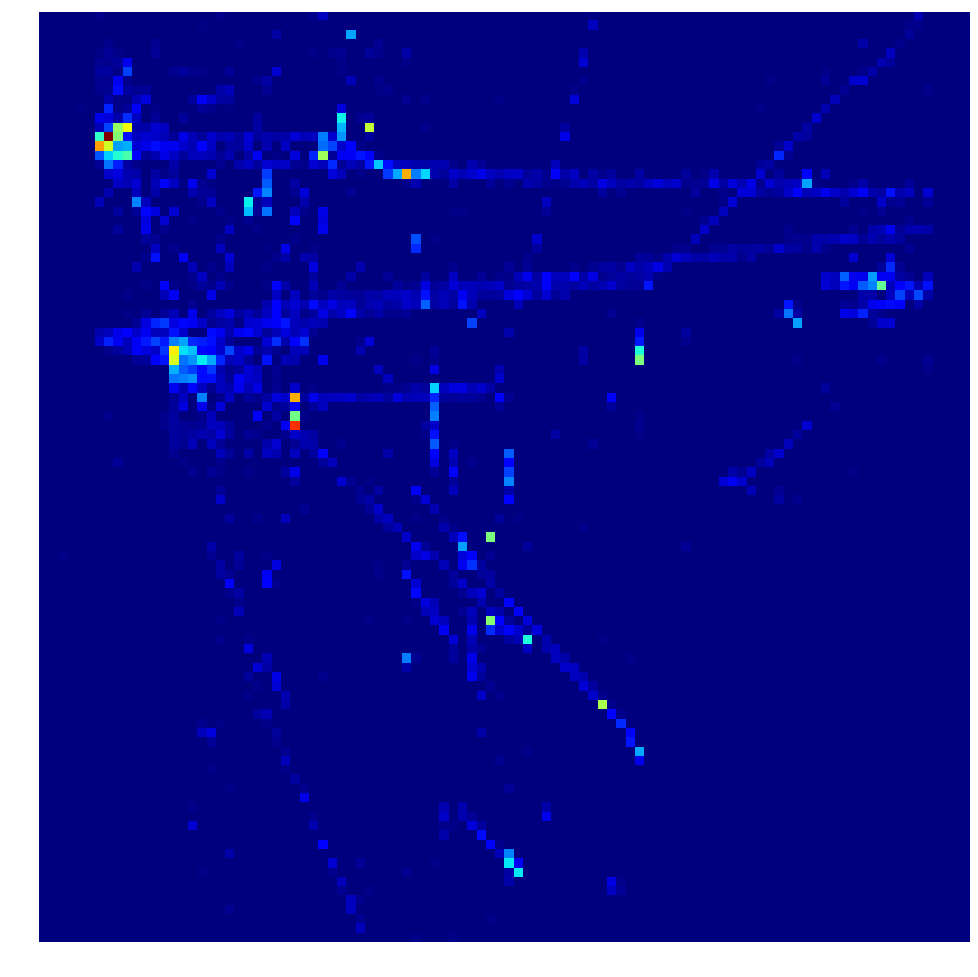

In [20]:
fig = plt.figure(figsize=(12, 12))
ax = plt.gca()
ax.axis('off')
im = ax.imshow(imgs[49], interpolation='nearest')

We need to aggregate pixel locations and colors in a loop over every pixel position. PK provided a function:

In [21]:
def split_image(img):
    """
    img needs 2d shape
    """
    xs = []  # positions
    ys = []  # colors
    for row_i in range(img.shape[0]):
        for col_i in range(img.shape[1]):
            xs.append([row_i, col_i])
            ys.append(img[row_i, col_i])
            
    xs = np.array(xs)
    ys = np.array(ys)
    return xs, ys

In [22]:
xs, ys = split_image(imgs[49])

In [23]:
print(xs[:10])
print(ys[:10])

[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [0 8]
 [0 9]]
[ 0.         0.         0.         0.         0.         0.         0.0109631
  0.         0.         0.       ]


PK wants us to normalize the input... but this makes no sense to me. The inputs are coordinates! So, we'll skip that.

We will do a `ys` normalization though:

In [24]:
print(np.min(ys), np.max(ys))

0.0 1.0


Hmmm, well, actually, we're already normalized. PK assumed we had 8-bit images and wanted a `/255` scaling, but I don't think that is required here.

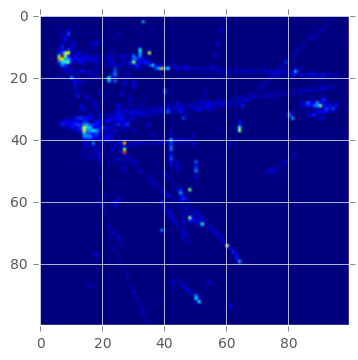

In [25]:
# we can get our image back:
plt.imshow(ys.reshape(imgs[49].shape))

Now, let's reset the graph and create placeholders for `X` and `Y`:

Here, we don't have color - only "pulse height." So, our outputs should not be `[None, 3]`, etc., but `[None, 1]`.

In [26]:
print(ys.shape)

(10000,)


In [27]:
ys = np.reshape(ys, [len(ys), 1])

In [28]:
print(ys.shape)

(10000, 1)


We seem to need the reshape to `(N, 1)` for everything to work.

In [29]:
tf.reset_default_graph()

In [30]:
[op.name for op in tf.get_default_graph().get_operations()]

[]

In [31]:
X = tf.placeholder(tf.float32, shape=[None, 2], name='X')
Y = tf.placeholder(tf.float32, shape=[None, 1], name='Y')  # pk has `3` here, for color output

In [32]:
[op.name for op in tf.get_default_graph().get_operations()]

['X', 'Y']

Now, let's create a 6-layer deep network with 20 neurons in each layer.

```
h1 = phi(X W1 + b1)
h2 = phi(h1 W2 + b2)
...
h6 = phi(h5 W6 + b6)
Yhat = phi(H6 W7 + b7)
```


In [33]:
# recall:
#  def linear(x, n_output, name=None, activation=None, reuse=None)
# `linear` returns activated layer, W

n_neurons = [2, 20, 20, 20, 20, 20, 20, 1]  # len==8, pk's ends with 3, of course
current_input = X
for layer_i in range(1, len(n_neurons)):
    # loop starting after the data input layer, use `linear` function to build params, etc.
    layer_name = 'layer_' + str(layer_i)
    act_fun = tf.nn.relu if (layer_i + 1) < len(n_neurons) else None
    # we also get back W, but we don't need it
    current_input, _ = linear(x=current_input, n_output=n_neurons[layer_i], name=layer_name, activation=act_fun)
Yhat = current_input

In [34]:
assert(X.get_shape().as_list() == [None, 2])
assert(Yhat.get_shape().as_list() == [None, 1])
assert(Y.get_shape().as_list() == [None, 1])

## Cost Function

\begin{equation}
\text{cost}(Y, \hat{Y}) = \frac{1}{B} \sum_{b = 0}^B E_b
\end{equation}

where the error is measured as:

\begin{equation}
E = \sum_{c=0}^C (Y_c - \hat{Y_c})^2
\end{equation}

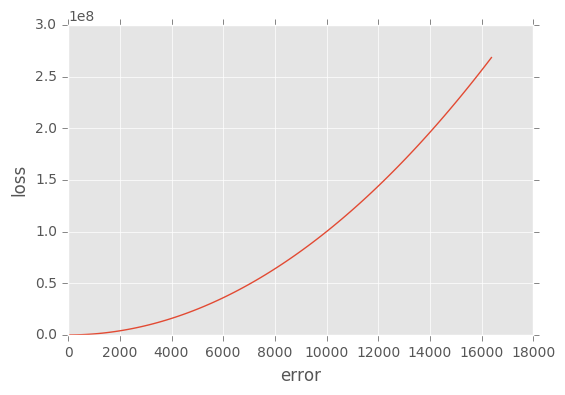

In [35]:
error = np.linspace(0.0, 128.0**2, 100)
loss = error ** 2
plt.plot(error, loss)
plt.xlabel('error')
plt.ylabel('loss')

This is the $l_2$ (ell-two) loss.

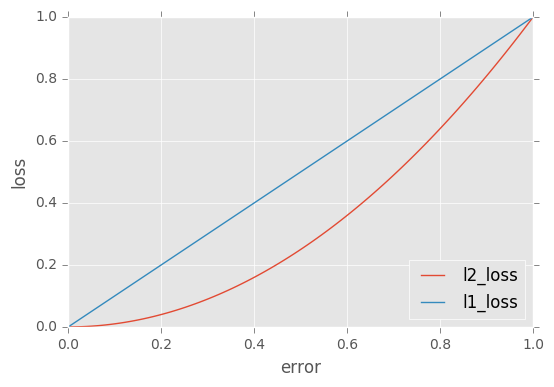

In [36]:
error = np.linspace(0.0, 1.0, 100)
plt.plot(error, error**2, label='l2_loss')
plt.plot(error, np.abs(error), label='l1_loss')
plt.xlabel('error')
plt.ylabel('loss')
plt.legend(loc='lower right')

Having a stronger penalty on smaller errors (e.g., the $l_1$ loss) leads to what the literature calls "sparse" solutions since it favors activations that try to explain as much of the data as possible, rahter than a lot of activations that do a sort of good job, but when put together do a great job of explaining the data.

In [37]:
error = tf.squared_difference(Y, Yhat)
assert(error.get_shape().as_list() == [None, 1])

In [38]:
help(tf.reduce_sum)

Help on function reduce_sum in module tensorflow.python.ops.math_ops:

reduce_sum(input_tensor, reduction_indices=None, keep_dims=False, name=None)
    Computes the sum of elements across dimensions of a tensor.
    
    Reduces `input_tensor` along the dimensions given in `reduction_indices`.
    Unless `keep_dims` is true, the rank of the tensor is reduced by 1 for each
    entry in `reduction_indices`. If `keep_dims` is true, the reduced dimensions
    are retained with length 1.
    
    If `reduction_indices` has no entries, all dimensions are reduced, and a
    tensor with a single element is returned.
    
    For example:
    
    ```python
    # 'x' is [[1, 1, 1]
    #         [1, 1, 1]]
    tf.reduce_sum(x) ==> 6
    tf.reduce_sum(x, 0) ==> [2, 2, 2]
    tf.reduce_sum(x, 1) ==> [3, 3]
    tf.reduce_sum(x, 1, keep_dims=True) ==> [[3], [3]]
    tf.reduce_sum(x, [0, 1]) ==> 6
    ```
    
    Args:
      input_tensor: The tensor to reduce. Should have numeric type.
      reducti

In [39]:
tmp = np.array([[1, 1, 1], [1, 1, 1]])
print(tmp.shape)

(2, 3)


In [40]:
np.sum(tmp, axis=1)

array([3, 3])

In [41]:
np.sum(tmp, axis=1).shape

(2,)

In [42]:
sum_error = tf.reduce_sum(error, reduction_indices=1)
assert(sum_error.get_shape().as_list() == [None])

In [43]:
cost = tf.reduce_mean(sum_error)
assert(cost.get_shape().as_list() == [])

Now we need an optimizer.

In [44]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

In [45]:
n_iterations = 100
batch_size = 10
learned_imgs = []
costs = []
gif_step = n_iterations // 10
step_i = 0
n_batches = len(xs) // batch_size

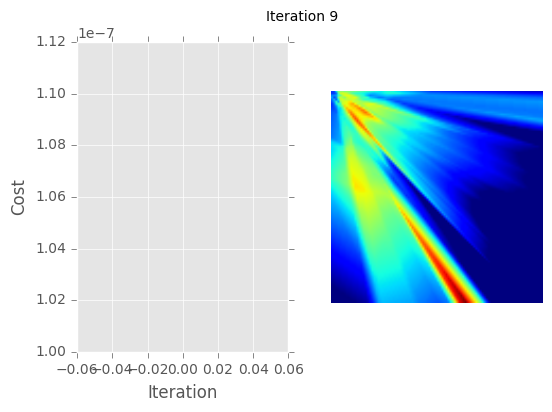

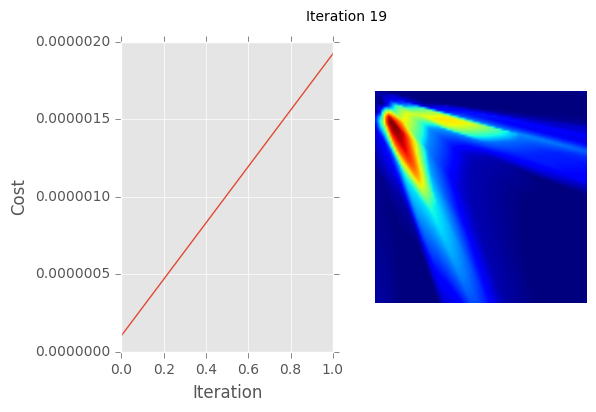

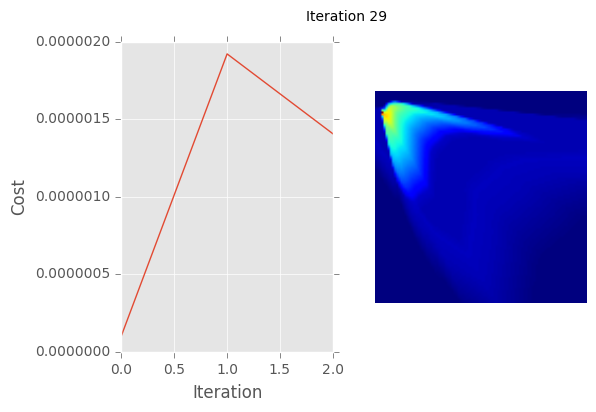

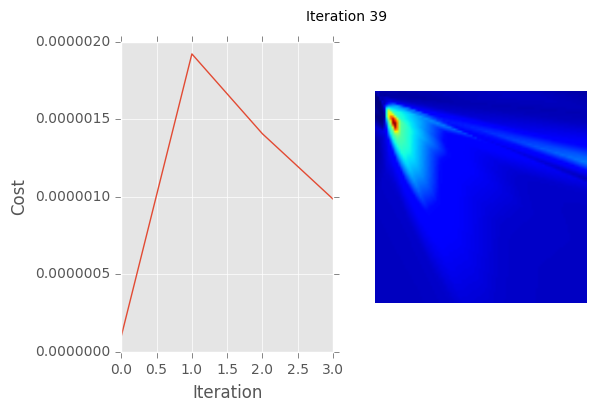

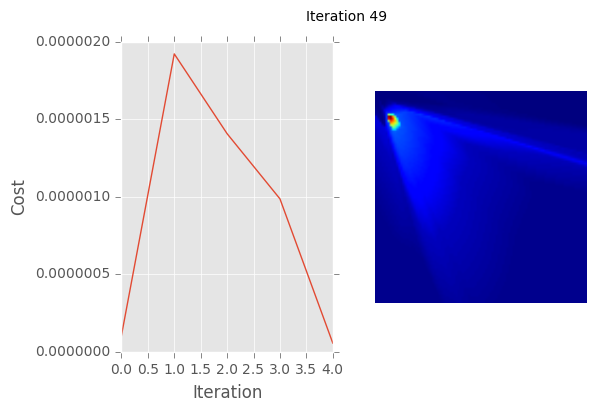

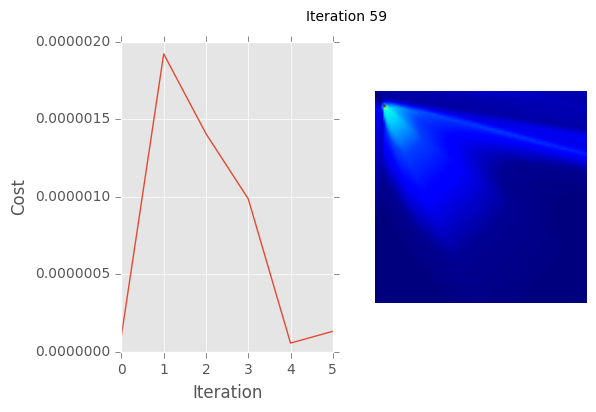

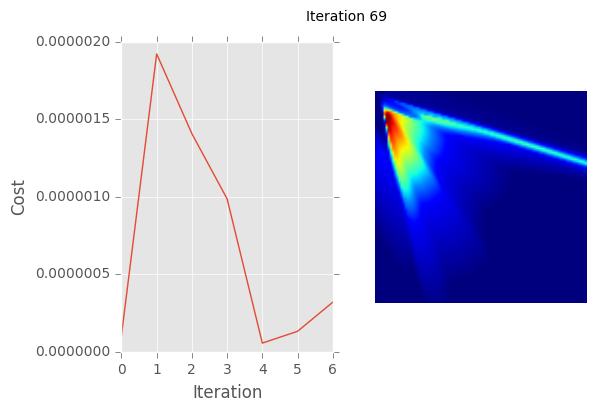

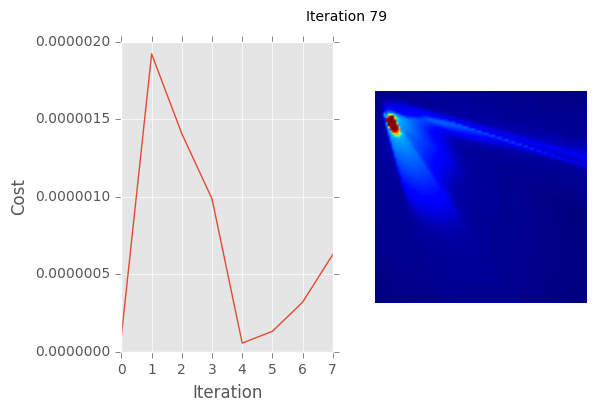

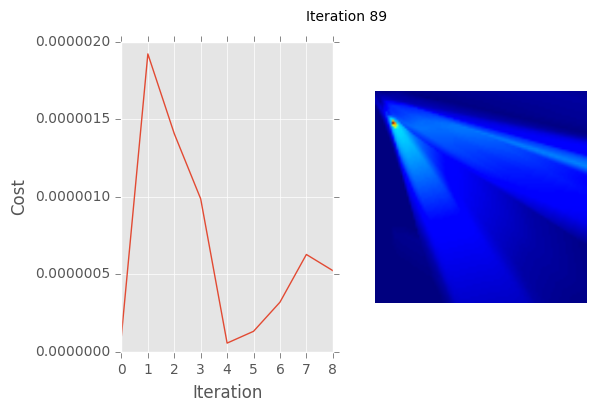

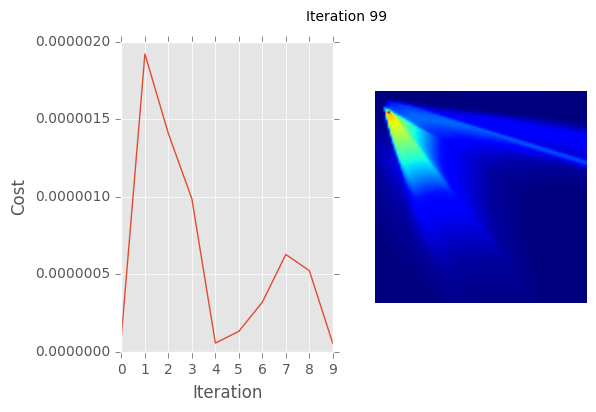

In [46]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for it_i in range(n_iterations):
        idxs = np.random.permutation(range(len(xs)))
        for batch_i in range(n_batches):
            idxs_i = idxs[batch_i * batch_size: (batch_i + 1) * batch_size]
            training_cost = sess.run([cost, optimizer], feed_dict={X: xs[idxs_i], Y: ys[idxs_i]})[0]
            
        if (it_i + 1) % gif_step == 0:
            costs.append(training_cost / n_batches)
            ys_pred = Yhat.eval(feed_dict={X: xs}, session=sess)
            img = np.clip(ys_pred.reshape(imgs[49].shape), 0, 1)
            learned_imgs.append(img)
            fig, ax = plt.subplots(1, 2)
            ax[0].plot(costs)
            ax[0].set_xlabel('Iteration')
            ax[0].set_ylabel('Cost')
            ax[1].imshow(img)
            ax[1].axis('off')
            fig.suptitle('Iteration {}'.format(it_i))
            plt.show()

In [47]:
np.shape(learned_imgs)

(10, 100, 100)

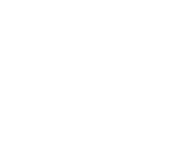

In [48]:
# save the bundle of imgs as a GIF
_ = gif.build_gif(learned_imgs, saveto='single.gif', show_gif=False)

In [49]:
ipyd.Image(url='single.gif?{}'.format(np.random.rand()), height=500, width=500)

## Explore

## A Note on Cross-validation

Usually we do train-val-test splits and cycle which part of the data is associated to which task.

## Part Three - Learning more than one image

We will also tell the network which image's row and column we want painted. Let's make functions `build_model` and `train` that take the previous code and wrap them into functions that take a 4d image set `N x H x W x C`. We have also updated the network structure with an input for the image number.

In [50]:
def build_model(xs, ys, n_neurons, n_layers, activation_fn, final_activation_fn, cost_type):
    """
    * xs, ys are _lists_ of coordinates and (here) pulse heights
    * n_layers does not count the final layer
    * we have n_neurons per created layer except for the final layer
    
    We use `linear` (and `flatten`) functions from above...
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    if xs.ndim != 2:
        raise ValueError('xs should be n_obs x n_features, or 2d')
    if ys.ndim != 2:
        raise ValueError('ys should be n_obs x n_features, or 2d')
        
    n_xs = xs.shape[1]
    n_ys = ys.shape[1]
    
    X = tf.placeholder(name='X', shape=[None, n_xs], dtype=tf.float32)
    Y = tf.placeholder(name='Y', shape=[None, n_ys], dtype=tf.float32)
    
    current_input = X
    for layer_i in range(n_layers):
        # get back h, W, but don't keep W here...
        current_input = linear(current_input, n_neurons, activation=activation_fn, name='layer{}'.format(layer_i))[0]
        
    Y_pred = linear(current_input, n_ys, activation=final_activation_fn, name='pred')[0]
    
    if cost_type == 'l1_norm':
        cost = tf.reduce_mean(tf.reduce_sum(tf.abs(Y - Y_pred), 1))
    elif cost_type == 'l2_norm':
        cost = tf.reduce_mean(tf.reduce_sum(tf.squared_difference(Y, Y_pred), 1))
    else:
        raise ValueError('Unknown cost type {}'.format(cost_type))
        
    return {
        'X': X, 'Y': Y, 'Y_pred': Y_pred, 'cost': cost
    }

In [51]:
def train(imgs,
         learning_rate=0.0001,
         batch_size=200,
         n_iterations=10,
         gif_step=2,
         n_neurons=30,
         n_layers=10,
         activation_fn=tf.nn.relu,
         final_activation_fn=tf.nn.tanh,
         cost_type='l2_norm'):
    N, H, W, C = imgs.shape
    print('all_xs, all_ys prep...')
    all_xs, all_ys = [], []
    for img_i, img in enumerate(imgs):
        xs, ys = split_image(img)
        all_xs.append(np.c_[xs, np.repeat(img_i, [xs.shape[0]])])
        all_ys.append(ys)
    print(' all_xs shape = {}'.format(np.shape(all_xs)))
    print(' all_ys shape = {}'.format(np.shape(all_ys)))

    xs = np.array(all_xs).reshape(-1, 3)
    # xs = (xs - np.mean(xs, 0)) / np.std(xs, 0)
    ys = np.array(all_ys).reshape(-1, 1)  # pk has `(-1, 3)` here because he has rgb images
    # ys already normalized here
    print(' xs shape = {}'.format(np.shape(xs)))
    print(' ys shape = {}'.format(np.shape(ys)))
    
    g = tf.Graph()
    with tf.Session(graph=g) as sess:
        model = build_model(xs, ys, n_neurons, n_layers,
                            activation_fn, final_activation_fn, cost_type)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(model['cost'])
        sess.run(tf.initialize_all_variables())
        gifs = []
        costs = []
        step_i = 0
        for it_i in range(n_iterations):
            idxs = np.random.permutation(range(len(xs)))
            n_batches = len(idxs) // batch_size
            training_cost = 0
            for batch_i in range(n_batches):
                idxs_i = idxs[batch_i * batch_size: (batch_i + 1) * batch_size]
                cost = sess.run([model['cost'], optimizer],
                               feed_dict={model['X']: xs[idxs_i],
                                         model['Y']: ys[idxs_i]})[0]
                training_cost += cost
                
            print('iteration {}/{}: cost {}'.format(it_i + 1, n_iterations, training_cost / n_batches))
        
            # every gif_step iters, draw the prediction of our
            # input xs, which should try to recreate the image
            if (it_i + 1) % gif_step == 0:
                costs.append(training_cost / n_batches)
                ys_pred = model['Y_pred'].eval(feed_dict={model['X']: xs}, session=sess)
                img = ys_pred.reshape(imgs.shape)
                gifs.append(img)
                
    gifs = np.array(gifs)        
    return gifs

In [71]:
tf.reset_default_graph()

In [72]:
imgs_t = np.array(imgs).copy()

In [73]:
imgs_t.shape

(100, 100, 100)

In [74]:
imgs_t = imgs_t.reshape([imgs_t.shape[0], imgs_t.shape[1], imgs_t.shape[2], 1])

In [75]:
imgs_t.shape

(100, 100, 100, 1)

In [76]:
np.repeat(0, [5])

array([0, 0, 0, 0, 0])

In [77]:
np.c_[[1, 2, 3, 4, 5], np.repeat(0, [5])]

array([[1, 0],
       [2, 0],
       [3, 0],
       [4, 0],
       [5, 0]])

In [78]:
np.c_[[1, 2, 3, 4, 5], np.repeat(1, [5])]

array([[1, 1],
       [2, 1],
       [3, 1],
       [4, 1],
       [5, 1]])

In [79]:
gifs = train(imgs=imgs_t, n_iterations=20)

all_xs, all_ys prep...
 all_xs shape = (100, 10000, 3)
 all_ys shape = (100, 10000, 1)
 xs shape = (1000000, 3)
 ys shape = (1000000, 1)
iteration 1/20: cost 0.0007857946458796505
iteration 2/20: cost 0.0005967490969302162
iteration 3/20: cost 0.0005882123809453333
iteration 4/20: cost 0.0005832124250827292
iteration 5/20: cost 0.0005803955435427269
iteration 6/20: cost 0.0005786120757414664
iteration 7/20: cost 0.0005776614504450208
iteration 8/20: cost 0.0005774413072950211
iteration 9/20: cost 0.0005768787015357702
iteration 10/20: cost 0.0005767288478662067
iteration 11/20: cost 0.0005763472094443387
iteration 12/20: cost 0.0005763597956081412
iteration 13/20: cost 0.0005763371100300901
iteration 14/20: cost 0.0005758770335088229
iteration 15/20: cost 0.000575952292586453
iteration 16/20: cost 0.0005757313732277453
iteration 17/20: cost 0.0005755706769199605
iteration 18/20: cost 0.0005753420494670991
iteration 19/20: cost 0.0005752442892276122
iteration 20/20: cost 0.0005750298946

In [80]:
np.array(gifs).shape

(10, 100, 100, 100, 1)

In [81]:
gifs = np.reshape(gifs,
                  (gifs.shape[0], gifs.shape[1], gifs.shape[2], gifs.shape[3]))
print("np.array(gifs).shape = {} (post reshape)".format(
    np.array(gifs).shape
))

np.array(gifs).shape = (10, 100, 100, 100) (post reshape)


10
(1011, 1011)
(1011, 1011)
(1011, 1011)
(1011, 1011)
(1011, 1011)
(1011, 1011)
(1011, 1011)
(1011, 1011)
(1011, 1011)
(1011, 1011)


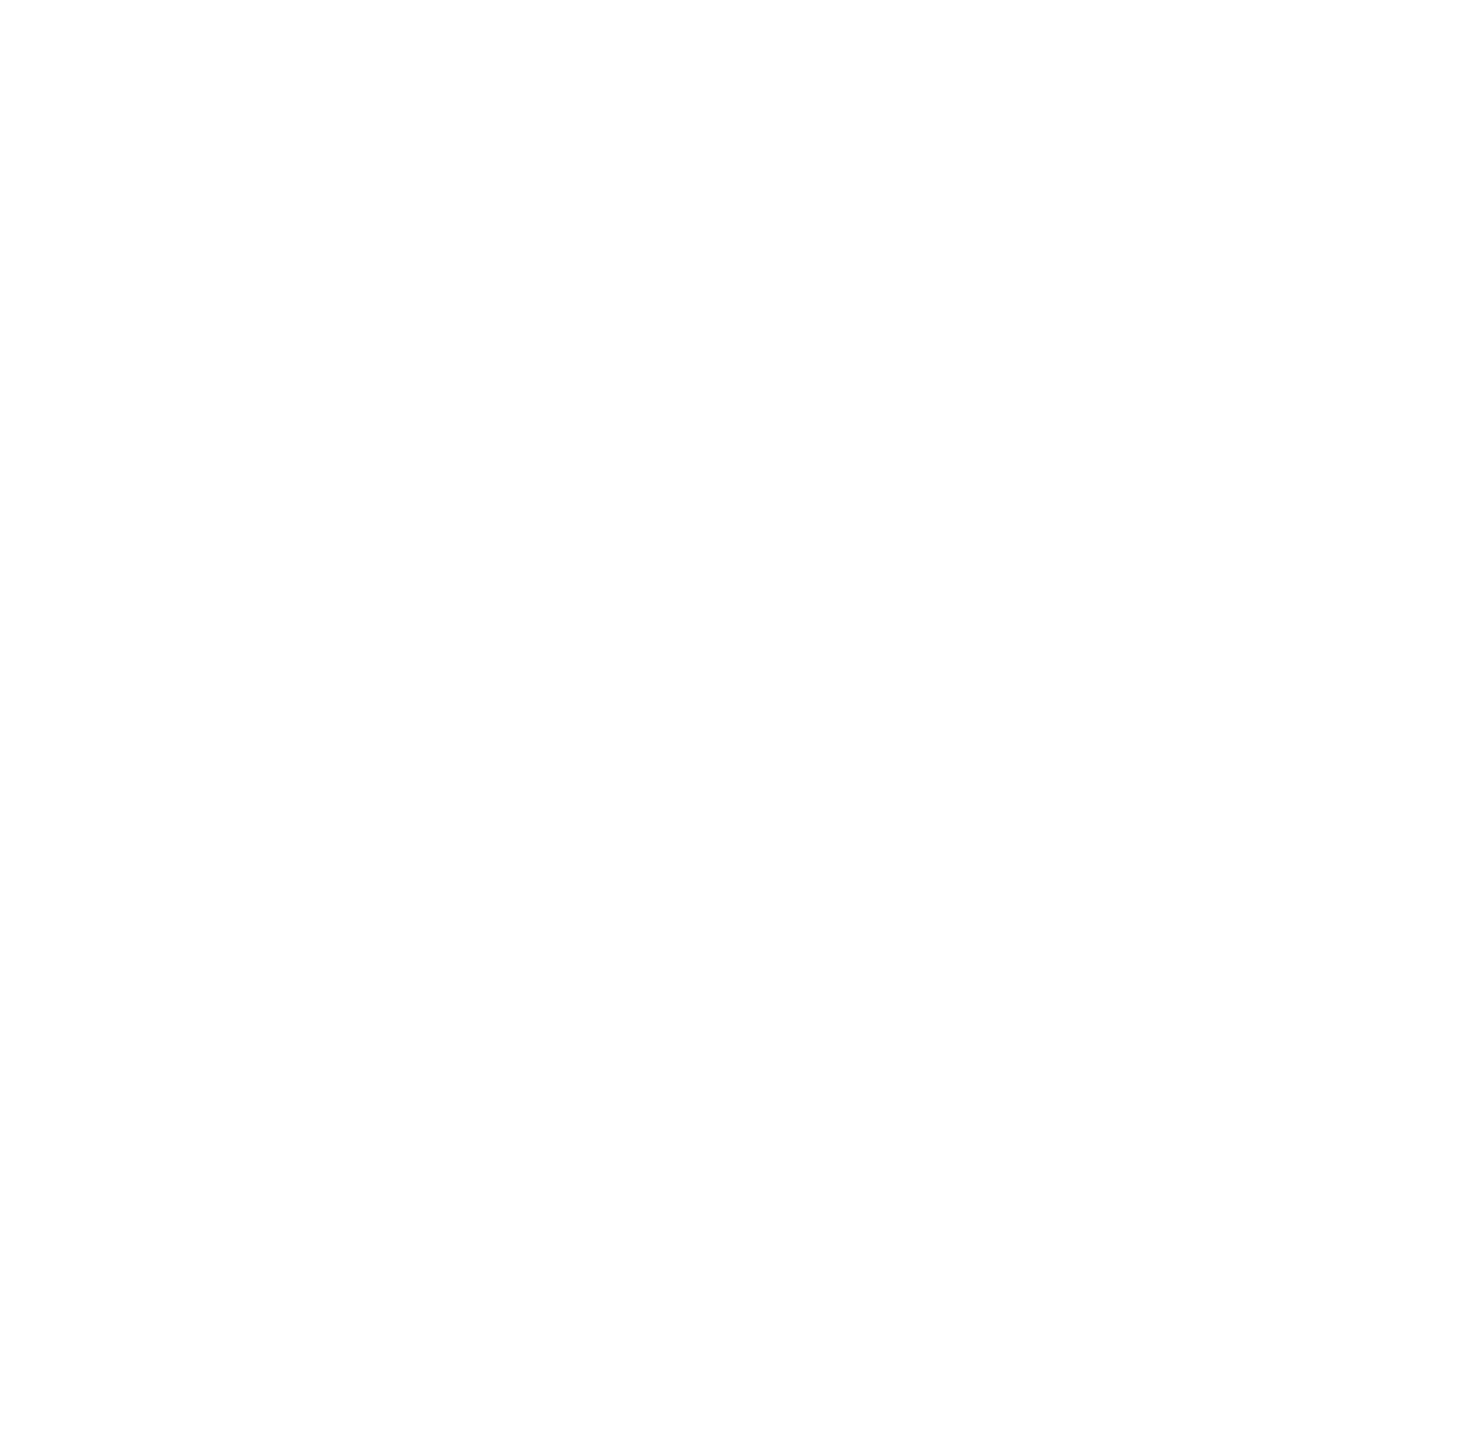

In [82]:
montage_gifs = [np.clip(utils.montage(g), 0, 1) for g in gifs]
print(len(montage_gifs))
for mg in montage_gifs:
    print(mg.shape)
_ = gif.build_gif(montage_gifs, saveto='multiple.gif')

In [83]:
# notebook only
ipyd.Image(url='multiple.gif?{}'.format(np.random.rand()), height=500, width=500)

In [84]:
final = gifs[:, :, :, 49]
print(final.shape)

(10, 100, 100)


In [85]:
final_gif = [np.clip(f, 0, 1) for f in final]
print(len(final_gif))
for fg in final_gif:
    print(fg.shape)

10
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)


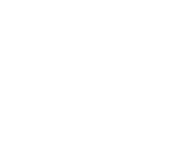

In [86]:
_ = gif.build_gif(final_gif, saveto='final.gif')

In [87]:
# notebook only
ipyd.Image(url='final.gif?{}'.format(np.random.rand()), height=200, width=200)